# Calculate frictional slopes (part 1): understanding shear fractures

Copyright 2020 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goals**: Understand the basics of shear fractures in the brittle field. The Coulomb failure criterion, Byerlees's and Amonton's laws, and the Hubbert-Rubey fluid-pressure hypothesis will be introduced.

In [1]:
# import the required Python scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set a custom figure style (optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'white'

## Step 1: Sliding on a dry fracture: the Amontons, Coulomb laws

### Amontons' law

The first attempt to determine which tangential shearing force is needed to displace two bodies in contact over an approximately planar surface was that of [Amontons](https://en.wikipedia.org/wiki/Guillaume_Amontons) in the 17th century (Amontons, 1699). Amontons established two principles: the tangential shearing force is independent on the contact area (first Amontons law of friction) and proportional to the normal load pressing the surfaces together (second Amontons law of friction). The second law of friction is expressed as follows

$\tau = \mu \sigma_n$

where $\tau$ is the _fracture shear strength_ or _critical shear stress_, $\sigma_n$ is the _fracture-normal stress_ and $\mu$ the so-called _internal coefficient of friction_ that relates both. The _coefficient of friction_ is, however, more properly referred to as the _coefficient of static friction_, since it refers to the condition required to initiate sliding (e.g. Jaeger et al. 2007). Indeed, the shear stress necessary for maintaining the frictional sliding at a constant velocity is always less than that required to initiate sliding and thus the _coefficient of dynamic friction_ is smaller ($\mu_d < \mu$).

[TODO → add figure 1 here!]()  
_Figure 1. The two main factors at play in terms of friction: fracture-normal stress and fracture shear strength_.

### Coulomb's law

General brittle failure is often described with the _Coulomb criterion_ (Coulomb 1773) that proposed the following relation

$\tau = C_0 + \mu \sigma_n$

where $C_0$ is the _cohesion of the fracture surface_ (or _frictional cohesive strenght_) that accounts for the resistance of the fracture plane to shear when the fracture-normal stress is zero. Coulomb also found that the _fracture shear strength_ is independent of the velocity of sliding, which is known as the (Coulomb) third law of friction.

Alternatively, the _coefficient of friction_ ($\mu$) is also expressed using the so-called _internal angle of friction_ $\phi$ (e.g. Mohr, 1900) or as a function of the angle between the principal stress $\sigma_1$ and the fracture plane orientation as follows

$\mu = tan\phi = - \frac{1}{tan 2\theta} = - cot(2\theta) = -cot(180 - 2\alpha))$

where $\theta$ and $\alpha$ are the angle between the principal stress $\sigma_1$ and the normal to the fracture plane and the fracture plane, respectively (Fig. 2).

[TODO → add figure 2 here!]()  
_Figure 2. Angular relationships between a shear fracture plane and the principal stress vectors in 2D._

The normal and shear stresses acting along any fracture plane can be estimated using the following relations (e.g. Twiss and Moores, 2007):

$\sigma_n = \frac{\sigma_1+\sigma_3}{2}+\frac{\sigma_1-\sigma_3}{2}cos2\theta$  

$\sigma_s = \frac{\sigma_1-\sigma_3}{2}sin2\theta$

Theoretically, faulting (or a shear fracture) should occur along the plane that maximizes the Amonton's and Coulomb's stress $\tau$ that takes into account both the normal and shear stresses acting on the fracture plane. The maximum resolved shear stress on a plane is obtained when the plane is oriented 45 degrees to the maximum principal stress. Most rocks deformed in confined compression, however, develop shear fractures with planes oriented less than 45 degrees from maximum compressive stress, so let's see what's happening here.

[Text(0.5, 0, '$\\alpha$ (degrees)'),
 Text(0, 0.5, '$\\mu = \\sigma_s / \\sigma_n$')]

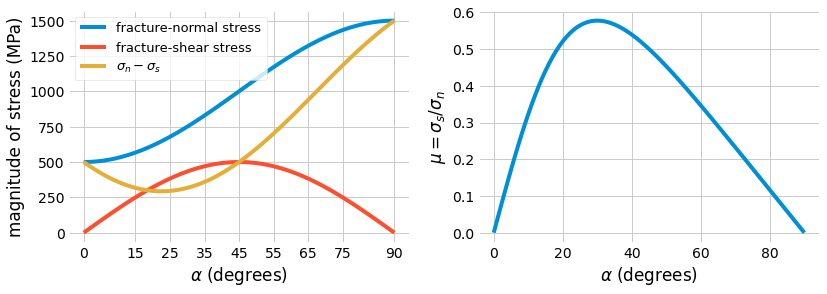

In [2]:
# estimate the whole range of (theta) angles between 0 and 90
angles = np.arange(start=0, stop=91)

# set the stress field (i.e. the magnitude of principal stresses in MPa)
sigma1, sigma2, sigma3 = 1500, 500, 500

# estimate normal and shear stresses (angles are converted to radians)
sigma_n = (sigma1 + sigma3) / 2 + ((sigma1 - sigma3) / 2) * np.cos(2 * np.deg2rad(angles))
sigma_s = ((sigma1 - sigma3) / 2) * np.sin(2 * np.deg2rad(angles))

# estimate the ratio between shear and normal stress (i.e. the coefficient of friction)
sigma_ratio = sigma_s / sigma_n
maximum = sigma_ratio[np.argmax(sigma_ratio)]  # numpy argmax returns the index of the maximum value

# make a plot with two axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# axe 1: magnitude of normal and shear stress
ax1.plot(90 - angles, sigma_n, label='fracture-normal stress')
ax1.plot(90 - angles, sigma_s, label='fracture-shear stress')
ax1.plot(90 - angles, sigma_n - sigma_s, label='$\sigma_n - \sigma_s$')

ax1.set(xlabel=r'$\alpha$ (degrees)', ylabel='magnitude of stress (MPa)')
ax1.set_xticks([0, 15, 25, 35, 45, 55, 65, 75, 90])
ax1.legend(loc='best', fontsize=13)

# axe 2: coefficent of friction
ax2.plot(90 - angles, sigma_ratio, label='$\sigma_s / \sigma_n$')
ax2.set(xlabel=r'$\alpha$ (degrees)', ylabel='$\mu = \sigma_s / \sigma_n$')

_Figure 3. Magnitude of normal and shear stress (left) and coefficent of friction (right) as a function of the fracture plane orientation ($\alpha$) respect to the principal stress $\sigma_1$._

Figure 3 shows that the normal-fault stress $\sigma_n$ is maximum when the fracture plane is arranged perpendicular to the maximum stress, here $\sigma_n =\sigma_1 = 1500$ MPa, and minimum when the fracture plane is parallel to the maximum stress, in this case by matching the minimum principal stress value $\sigma_n =\sigma_3 = 500$ MPa. Regarding the shear stress $\sigma_s$, the maximum value is reached at a plane oriented 45 degrees from the maximum principal stress, being the magnitude half as large as the applied differential stress (i.e. $\sigma_d/2 = 500$ MPa), and becoming zero at the extremes (angles 0 and 90). TODO

In [3]:
# estimate the angle of friction for which the ratio is maximum
critical_angle = 90 - angles[np.argmax(sigma_ratio)]

print(f'The maximum ratio (of {round(maximum, 2)}) between the shear and the normal stress \
      \nis given at an angle of {critical_angle} degrees.')

The maximum ratio (of 0.58) between the shear and the normal stress       
is given at an angle of 30 degrees.


## Step 2: Byerlee empirical relation

Based on a large number of laboratory measures, Byerlee (1978) determine the _coefficient of friction_ ($\mu$) and the _cohesive strength_ $C_0$ for a broad range of rock types. He found that $\mu$ is independent temperature, the rate of deformation and, largely, the rock type; being some notable exceptions clay-rich rocks such as slates or serpentinites. Byerlee provided two empirical expressions depending on pressure often referred to as _Byerlee's Law_

for 5 < σ < 200 MPa (where 200 MPa is equivalent to a depth of ~8 km in the continental crust)  
$\tau = 0.85 \sigma$  

for 200 < σ < 1700 MPa  
$\tau = 50 + 0.6 \sigma$

TODO

## Step 3: Sliding on a wet facture: the Hubbert-Rubey fluid-pressure hypothesis

Coulomb's model and Byerlee's parameters successfully predict many observations about fragile faults (see examples in Twiss and Moores, 2007), there are however notable exceptions such as flat ramps in thrust faults...(the mechanical paradox) TODO

This paradox was solved by the Hubert and Rubey model ([Hubbert and Rubey 1959](https://pubs.geoscienceworld.org/gsa/gsabulletin/article-abstract/70/2/115/5071/ROLE-OF-FLUID-PRESSURE-IN-MECHANICS-OF-OVERTHRUST)). Based on previous knowledge of soil mechanics (Terzagui 1936), Hubbert and Rubey envisioned that the _fault shear strength_ not only depends on the _fault‐normal stress_ and the _internal coefficient of friction_ but also the fluid pore pressure. Intuitively, this means that a fluid under pressure along the fracture plane exerts a force that counteracts the _fault‐normal stress_ and, hence, the higher the fluid pore pressure, the smaller the _fault shear strength_ ($\tau$). This model allows mechanically unfavourable faults to be explained and has been confirmed with direct and indirect measures several times (e.g. [Aydin and Engelder, 2014](https://doi.org/10.1016/j.jsg.2014.07.010); [Suppe, 2014](https://doi.org/10.1016/j.jsg.2014.07.009)). This model adds the concept of _effective normal stress_ $\sigma_{n}^{eff}$, which is the fault-normal stress taking into account the fluid pore pressure as follows

$\tau = C_0 + \mu \sigma_{n}^{eff} = C_0 + \mu (\sigma_n - P_f)$

where $P_f$ is the pore fluid pressure.

An alternative way of articulating this using the ratio between the pore fluid pressure and the lithostatic stress $\lambda = P_f / \sigma_L$ as follows

$\tau = C_0 + \mu \sigma_n (1-\lambda)$

that hold for the cases when $\sigma_L \approx \sigma_n$

> **Keys and clues**
>- Amontons and Coulomb's laws indicate that the _fracture shear strength_ increases linearly with fracture-normal stress. As fracture-normal stress increases with confining pressure, brittle failure becomes difficult with depth.
>- According to Amontons, Coulomb and Byerlee, the _coefficient of friction_ is largely independent of temperature, rate of deformation, and rock type. The latter explains why a brittle fault can cut across different lithologies with no change in angle.
>- Although somewhat counterintuitive, the cohesive strength of the rocks in the crust is negligible as they are preexisting fracture planes everywhere. There is strong evidence on this from studies measuring the stress state along superdeep boreholes (e.g. [Emmermann and Lauterjung, 1997](https://doi.org/10.1029/96JB03945)). The parameter $C_0$ in Coulomb's is therefore used to account for the _frictional cohesive strength_ or just taken as zero.
>- Note that using the relation $\mu = -cot(2\theta))$ and for $\mu$ values of 0.6-0.85 (as set by Byerlee) most faults (shear fractures) must occur at 25-30 degrees to the maximum principal stress ($\sigma_1$), as is often observed in nature (with notable exceptions such as low-angle faults).
>- All models presented here are valid for _shear fractures_ not for _extensional fractures_ (the latter are better explained by the Griffith theory of fracture).
>
>_**Aside note**: keep in mind that the Coulomb and Amontons' laws are not flow laws (i.e. do not relate stress and strain or strain rate) but a model that describes the critical state at which brittle failure occurs within the brittle field_.